<a href="https://colab.research.google.com/github/pasancardiffmet/CMP7005-PRAC1/blob/main/ST20319008_CMP7005_PRAC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Beijing Air Quality Analysis


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("dark")

In [2]:
# Load the datasets
df_changping = pd.read_csv('PRSA_Data_Changping_20130301-20170228.csv')
df_dongsi = pd.read_csv('PRSA_Data_Dongsi_20130301-20170228.csv')
df_gucheng = pd.read_csv('PRSA_Data_Gucheng_20130301-20170228.csv')
df_huairou = pd.read_csv('PRSA_Data_Huairou_20130301-20170228.csv')

# Add the Site Category column
df_changping['category'] = 'Suburban'
df_dongsi['category'] = 'Urban'
df_gucheng['category'] = 'Industrial'
df_huairou['category'] = 'Rural'

#Merging the Dataset
df_list = [df_changping, df_dongsi, df_gucheng, df_huairou]
merged_df = pd.concat(df_list, ignore_index=True)
merged_df['datetime'] = pd.to_datetime(merged_df[['year', 'month', 'day', 'hour']])
# Rearranging and replacing redundant columns
cols = ['datetime', 'station', 'category', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3',
        'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd','WSPM']
merged_df = merged_df[cols]

merged_df.head()
# Save merged dataset
# merged_df.to_csv('merged_beijing_air_quality.csv', index=False)
# Display the first few rows of each DataFrame
# display(df_changping.head())
# display(df_dongsi.head())
# display(df_gucheng.head())
# display(df_huairou.head())

In [3]:
#Descriptive Statistics
print(f"Total rows in merged dataset: {merged_df.shape[0]}")
print(f"Total columns in merged dataset: {merged_df.shape[1]}")
print("Information about the merged dataset:")
print(merged_df.info(),'\n')
print("Descriptive statistics of the merged dataset:")
print(merged_df.describe(),'\n')
print("\nUnique value counts in categorical columns:")
print("\nUnique values in Station column:")
print(merged_df['station'].value_counts())
print("\nUnique values in Category column:")
print(merged_df['category'].value_counts())
print("\nUnique values in Wind Direction column:")
print(merged_df['wd'].value_counts())
print("\nMissing values and Percentaged per Column:")
missing_values = merged_df.isnull().sum()
missing_percentage = (merged_df.isnull().sum() / len(merged_df)) * 100
missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage (%)': missing_percentage})
print(missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))

Total rows in merged dataset: 140256
Total columns in merged dataset: 15
Information about the merged dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  140256 non-null  datetime64[ns]
 1   station   140256 non-null  object        
 2   category  140256 non-null  object        
 3   PM2.5     137133 non-null  float64       
 4   PM10      137963 non-null  float64       
 5   SO2       137478 non-null  float64       
 6   NO2       135681 non-null  float64       
 7   CO        132715 non-null  float64       
 8   O3        137108 non-null  float64       
 9   TEMP      140081 non-null  float64       
 10  PRES      140083 non-null  float64       
 11  DEWP      140079 non-null  float64       
 12  RAIN      140087 non-null  float64       
 13  wd        139577 non-null  object        
 14  WSPM      140108 non-

In [4]:
#Handling the numerical missing values in the numerical columns

#Since these are time series data, and the number of pollutends are likely be similar to the previous value in the time series (assuming no drastic changes)
#filling with the previous valuee with ffill makes the most sense
numerical_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for col in numerical_cols:
    merged_df[col] = merged_df[col].ffill()

# Fill missing values in 'wd' categorical column with the mode (most common item)
merged_df['wd'] = merged_df['wd'].fillna(merged_df['wd'].mode()[0])

#Drop any duplicate columns if there are any
merged_df.drop_duplicates()
merged_df
# Save the processed merged dataset
merged_df.to_csv('merged_beijing_air_quality.csv', index=False)

In [9]:
# Statistical Summary after Processing
print("\nStatistical Summary - After Processing")
numerical_cols2 = merged_df.select_dtypes(include=np.number).columns.tolist() # Changed to merged_df
print(merged_df[numerical_cols2].describe().transpose()) # Changed to merged_df


Statistical Summary - After Processing
          count         mean          std       min     25%     50%     75%  \
PM2.5  140256.0    77.931130    78.924504    2.0000    20.0    53.0   109.0   
PM10   140256.0   104.340482    92.153466    2.0000    36.0    81.0   145.0   
SO2    140256.0    15.442013    22.814735    0.2856     2.0     7.0    19.0   
NO2    140256.0    46.079629    33.268190    1.0265    20.0    38.0    65.0   
CO     140256.0  1224.597308  1131.734753  100.0000   500.0   900.0  1500.0   
O3     140256.0    58.906484    57.209876    0.2142    14.0    46.0    82.0   
TEMP   140256.0    13.406316    11.485187  -19.9000     3.0    14.4    23.1   
PRES   140256.0  1009.193025    10.350625  982.4000  1000.8  1008.9  1017.4   
DEWP   140256.0     2.187756    13.879717  -43.4000    -9.4     2.6    14.9   
RAIN   140256.0     0.064171     0.807283    0.0000     0.0     0.0     0.0   
WSPM   140256.0     1.677711     1.254865    0.0000     0.9     1.3     2.1   

           

#Data Analysis

##Univariate Analysis

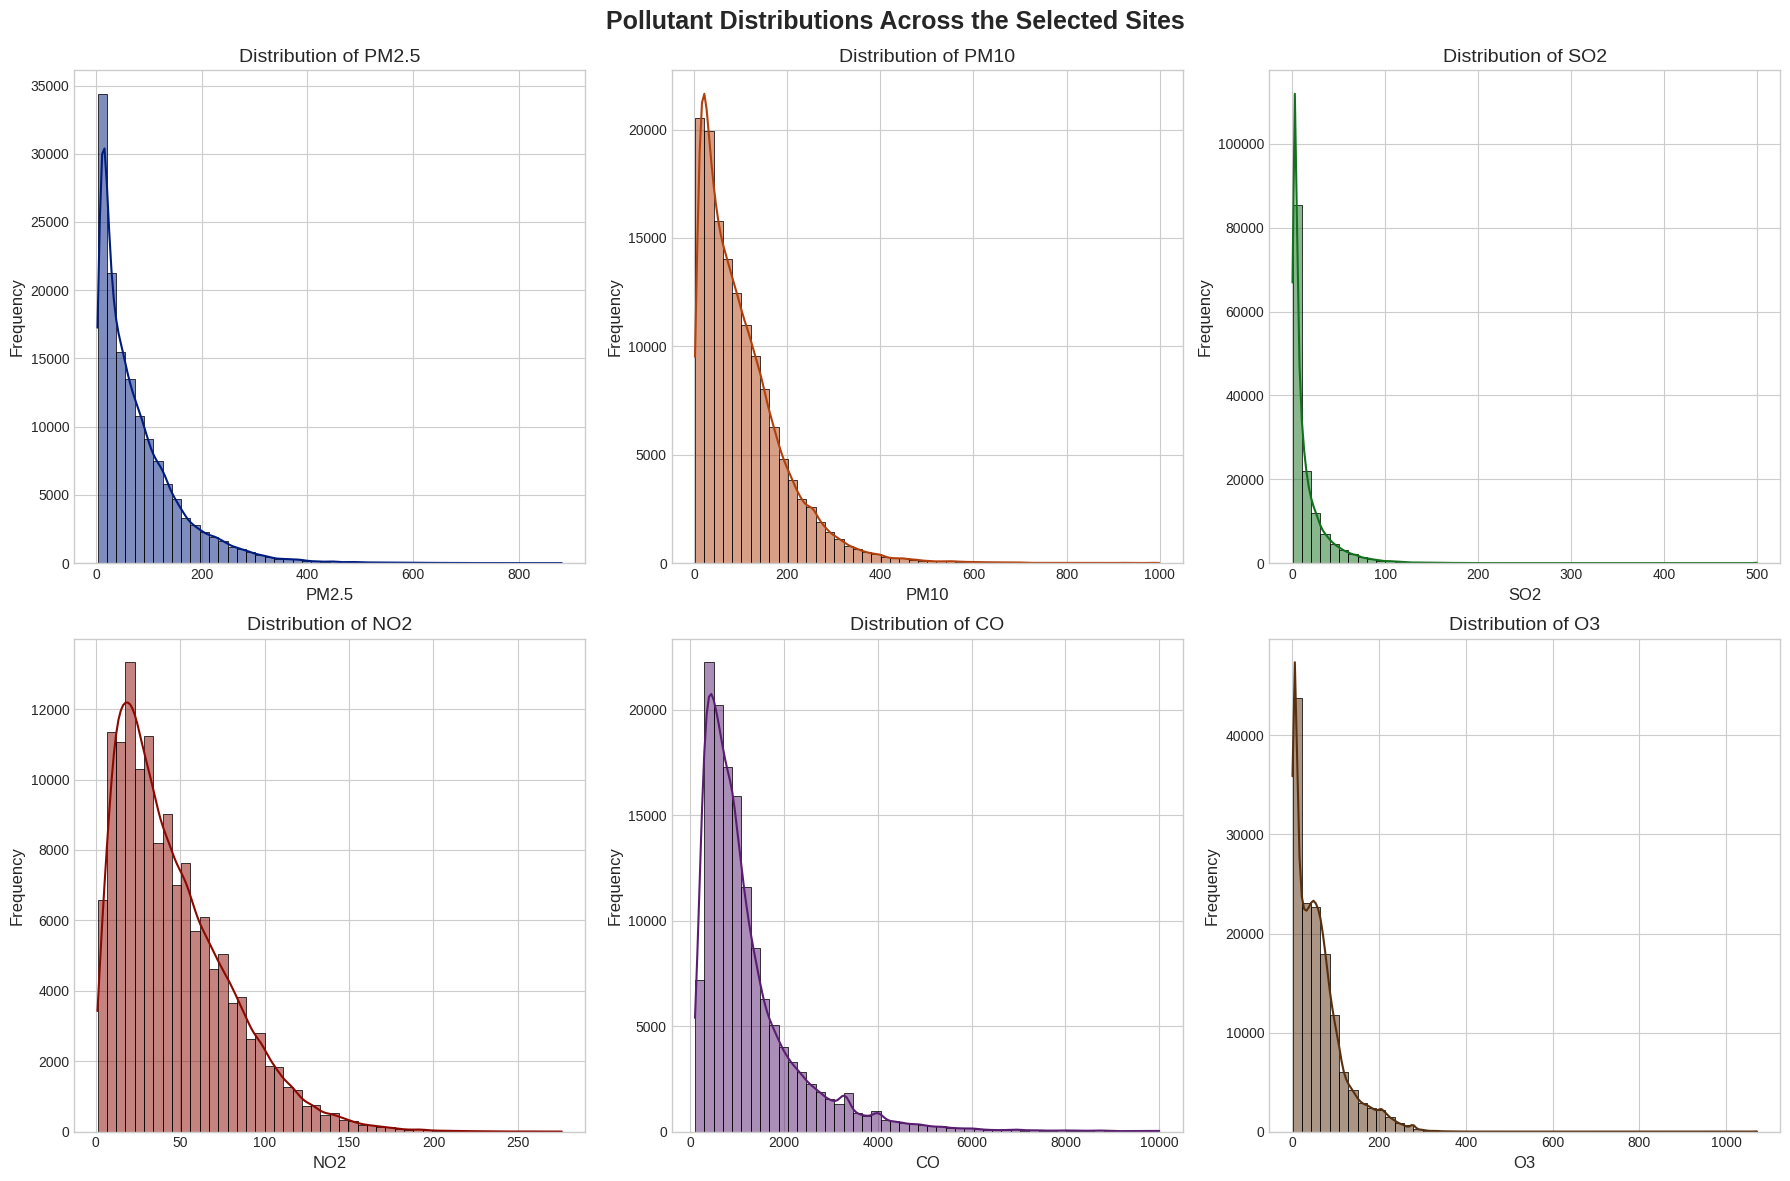

In [11]:
#Univariate Analysis - Pollutant Distributions
#Analysing Pollutant Distributions using Histograms
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
plt.figure(figsize=(18, 12))
for i, col in enumerate(pollutants):
    if col in merged_df.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(merged_df[col], kde=True, bins=50, color=sns.color_palette("dark")[i % len(sns.color_palette("dark"))])
        plt.title(f'Distribution of {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Pollutant Distributions Across the Selected Sites", fontsize=18, fontweight='bold')
plt.show()

In [17]:
# # Box plots for pollutants by Location category
# plt.figure(figsize=(18, 15))

# for i, col in enumerate(pollutants):
#     if col in merged_df.columns and 'category' in merged_df.columns:
#         plt.subplot(2, 3, i + 1)
#         sns.boxplot(x='category', y=col, data=merged_df, order=category_order, palette="dark")
#         plt.xlabel('Location Category', fontsize=12)
#         plt.ylabel(f'{col} (Concentration)', fontsize=12)
#         plt.xticks(rotation=15, ha='right')
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.suptitle("Pollutant Levels by Location Category", fontsize=18, fontweight='bold')
# plt.show()

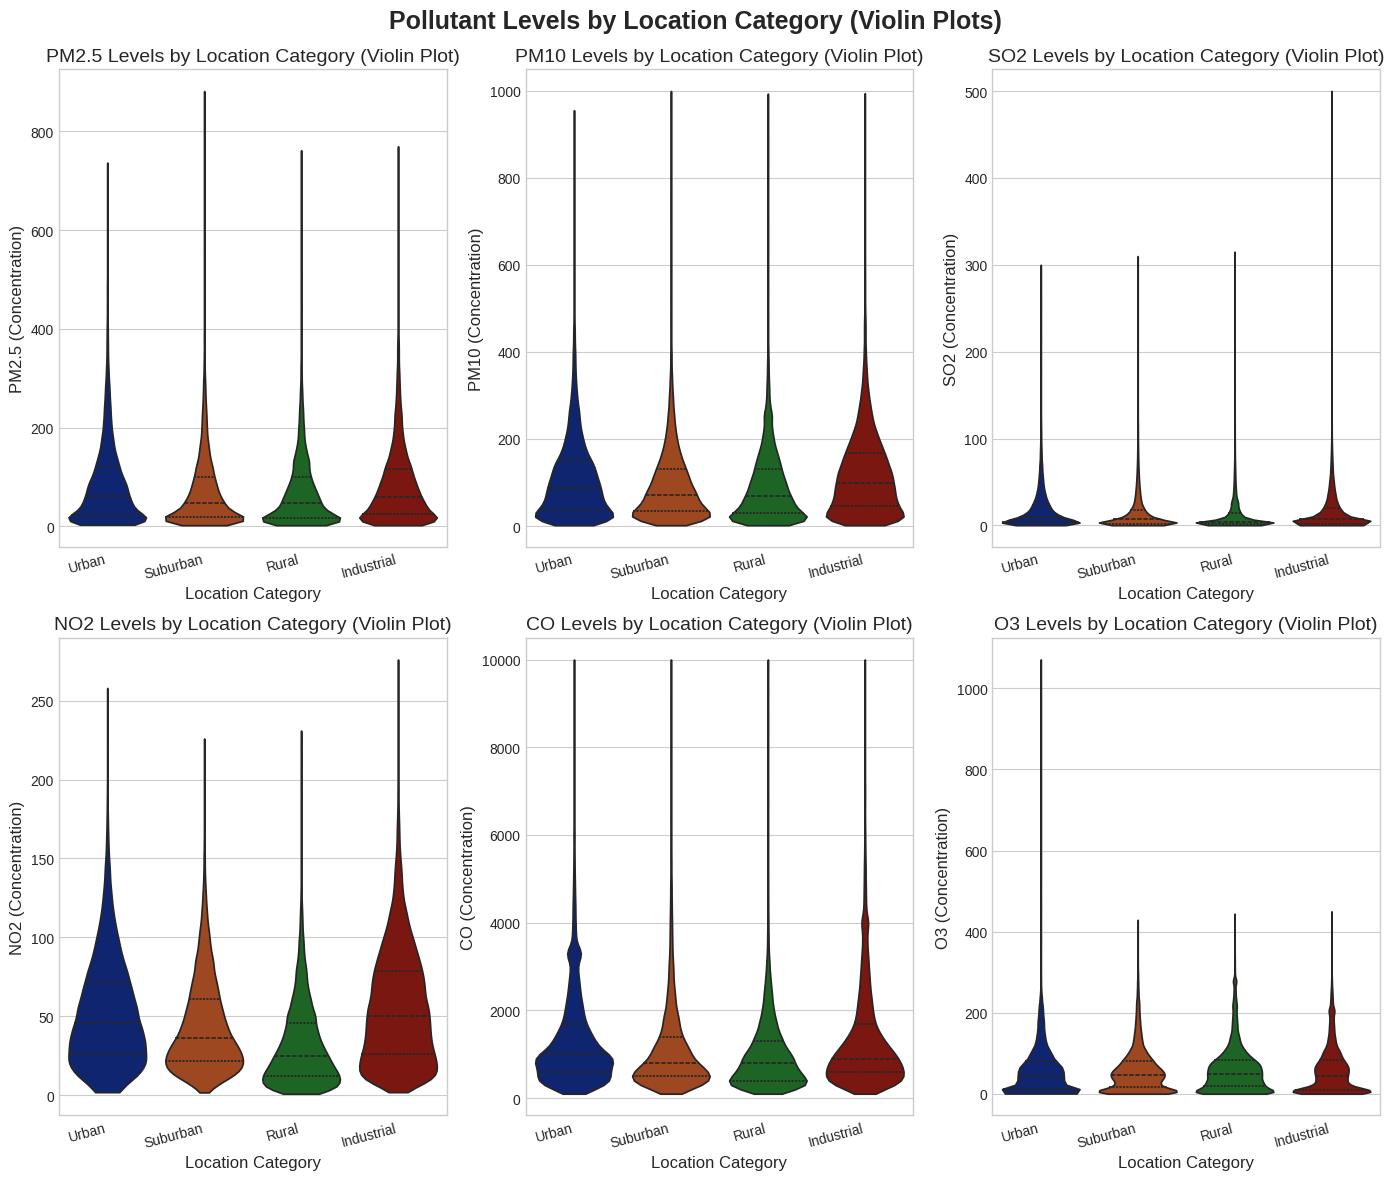

In [20]:
# Violin plots for pollutants by Location category - Violin Plots allow for more cleaner visualization than box plots
category_order = ['Urban', 'Suburban', 'Rural', 'Industrial']
plt.figure(figsize=(14, 12))
for i, col in enumerate(pollutants):
    if col in merged_df.columns and 'category' in merged_df.columns:
        plt.subplot(2, 3, i + 1)
        sns.violinplot(x='category', y=col, data=merged_df, order=category_order, palette="dark", inner="quartile", cut=0)
        # inner="quartile" shows lines for quartiles inside the violin
        # cut=0 ensures the violin plot doesn't extend beyond the data range
        plt.title(f'{col} Levels by Location Category (Violin Plot)', fontsize=14)
        plt.xlabel('Location Category', fontsize=12)
        plt.ylabel(f'{col} (Concentration)', fontsize=12)
        plt.xticks(rotation=15, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Pollutant Levels by Location Category (Violin Plots)", fontsize=18, fontweight='bold')
plt.show()


##Bivariate Analysis


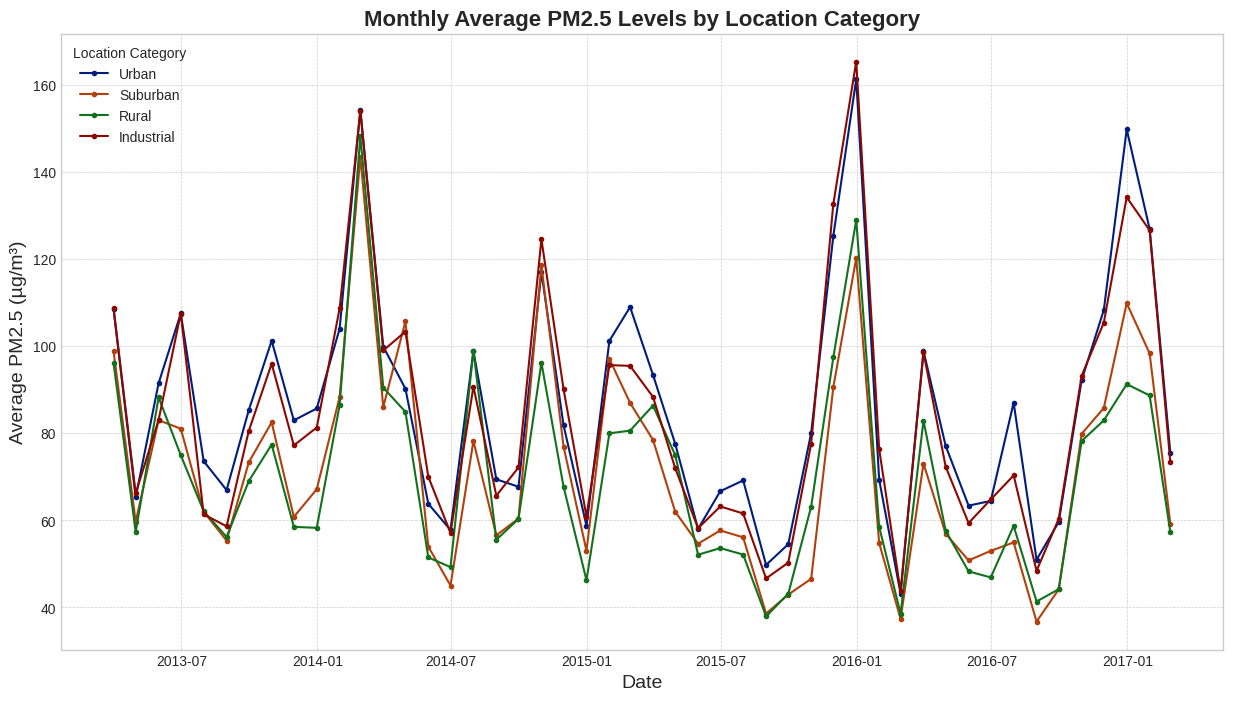

In [21]:
# Time series plot of PM2.5 (monthly average for each Location category)
plt.figure(figsize=(15, 8))
temp_df_for_ts = merged_df.set_index('datetime')
palette_colors = sns.color_palette("dark", n_colors=len(category_order))
category_colors = {cat: palette_colors[i] for i, cat in enumerate(category_order)}

for category_name in category_order:
    if category_name in temp_df_for_ts['category'].unique():
        category_data = temp_df_for_ts[temp_df_for_ts['category'] == category_name]
        monthly_avg_pm25 = category_data['PM2.5'].resample('M').mean() #Getting Monthly Average Temperatures
        plt.plot(monthly_avg_pm25.index, monthly_avg_pm25.values, label=category_name, marker='.', linestyle='-', color=category_colors.get(category_name))
plt.title('Monthly Average PM2.5 Levels by Location Category', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average PM2.5 (µg/m³)', fontsize=14)
plt.legend(title='Location Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

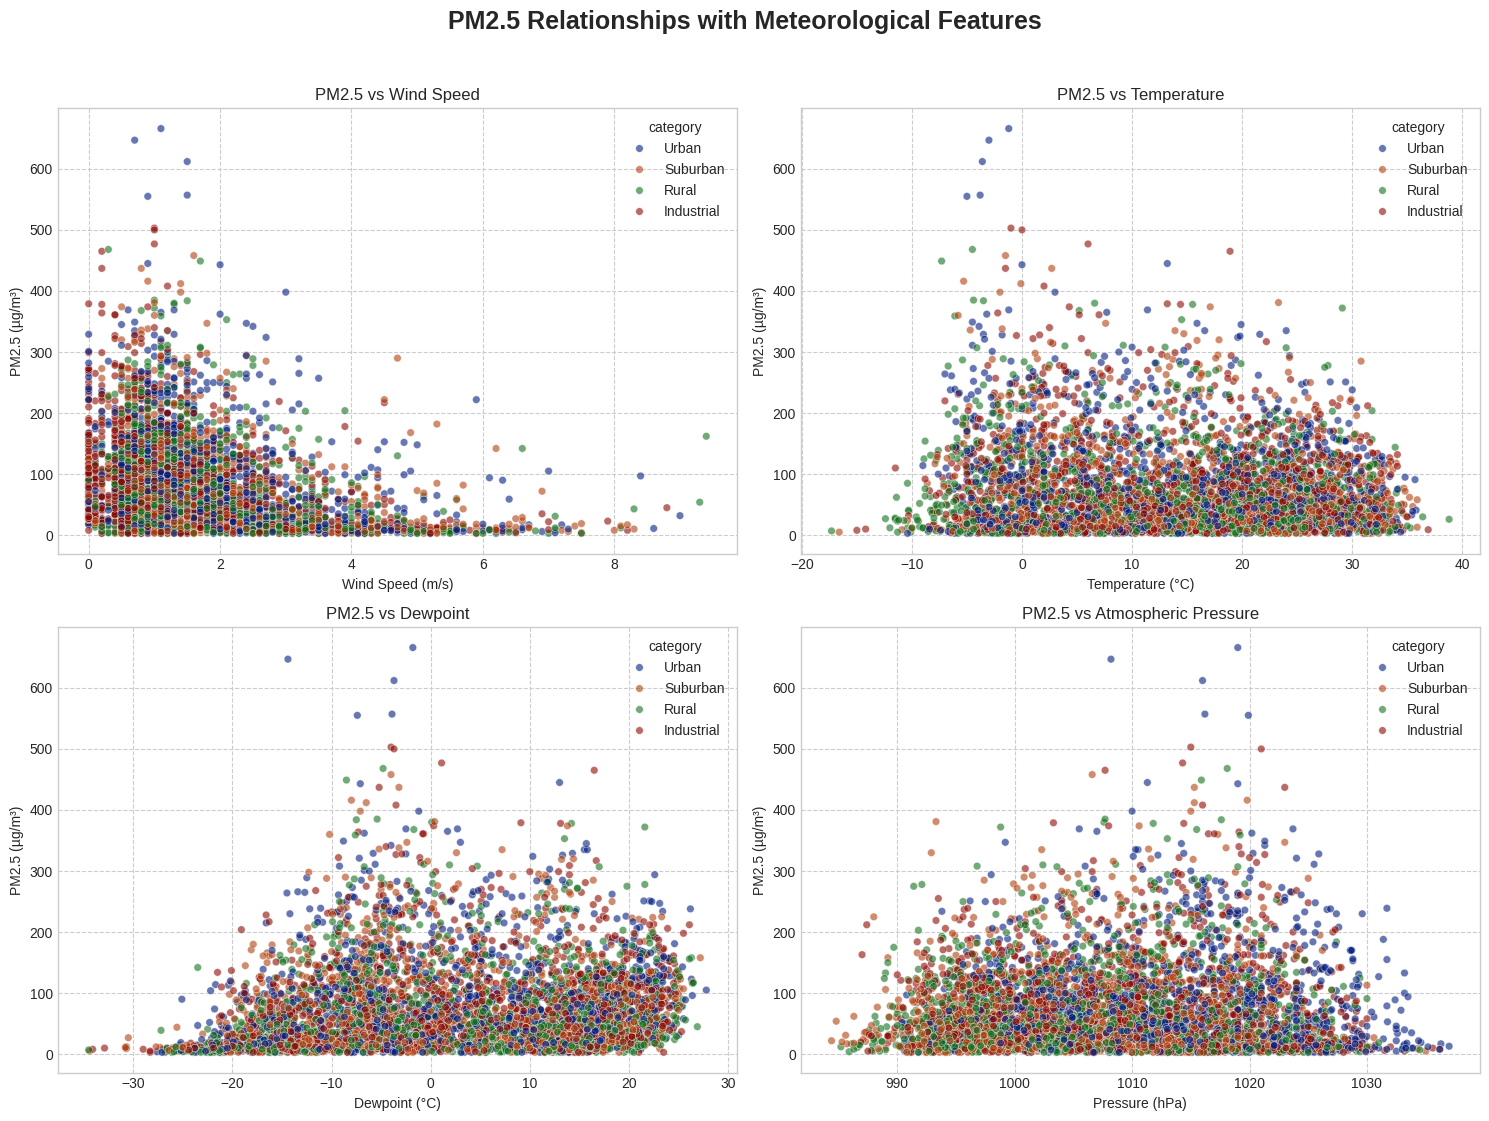

In [36]:
# Sample for performance and clarity because the dataset is very large (over 140000 datapoints)
sample_df = merged_df.sample(n=min(5000, len(merged_df)), random_state=42)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('PM2.5 Relationships with Meteorological Features', fontsize=18, fontweight='bold')

# PM2.5 vs Wind Speed
sns.scatterplot(ax=axes[0, 0], x='WSPM', y='PM2.5', data=sample_df, hue='category',
                alpha=0.6, s=30, hue_order=category_order, palette="dark")
axes[0, 0].set_title('PM2.5 vs Wind Speed')
axes[0, 0].set_xlabel('Wind Speed (m/s)')
axes[0, 0].set_ylabel('PM2.5 (µg/m³)')
axes[0, 0].grid(True, linestyle='--')

# PM2.5 vs Temperature
sns.scatterplot(ax=axes[0, 1], x='TEMP', y='PM2.5', data=sample_df, hue='category',
                alpha=0.6, s=30, hue_order=category_order, palette="dark")
axes[0, 1].set_title('PM2.5 vs Temperature')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('PM2.5 (µg/m³)')
axes[0, 1].grid(True, linestyle='--')

# PM2.5 vs Dewpoint
sns.scatterplot(ax=axes[1, 0], x='DEWP', y='PM2.5', data=sample_df, hue='category',
                alpha=0.6, s=30, hue_order=category_order, palette="dark")
axes[1, 0].set_title('PM2.5 vs Dewpoint')
axes[1, 0].set_xlabel('Dewpoint (°C)')
axes[1, 0].set_ylabel('PM2.5 (µg/m³)')
axes[1, 0].grid(True, linestyle='--')

# PM2.5 vs Atmospheric Pressure
sns.scatterplot(ax=axes[1, 1], x='PRES', y='PM2.5', data=sample_df, hue='category',
                alpha=0.6, s=30, hue_order=category_order, palette="dark")
axes[1, 1].set_title('PM2.5 vs Atmospheric Pressure')
axes[1, 1].set_xlabel('Pressure (hPa)')
axes[1, 1].set_ylabel('PM2.5 (µg/m³)')
axes[1, 1].grid(True, linestyle='--')

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


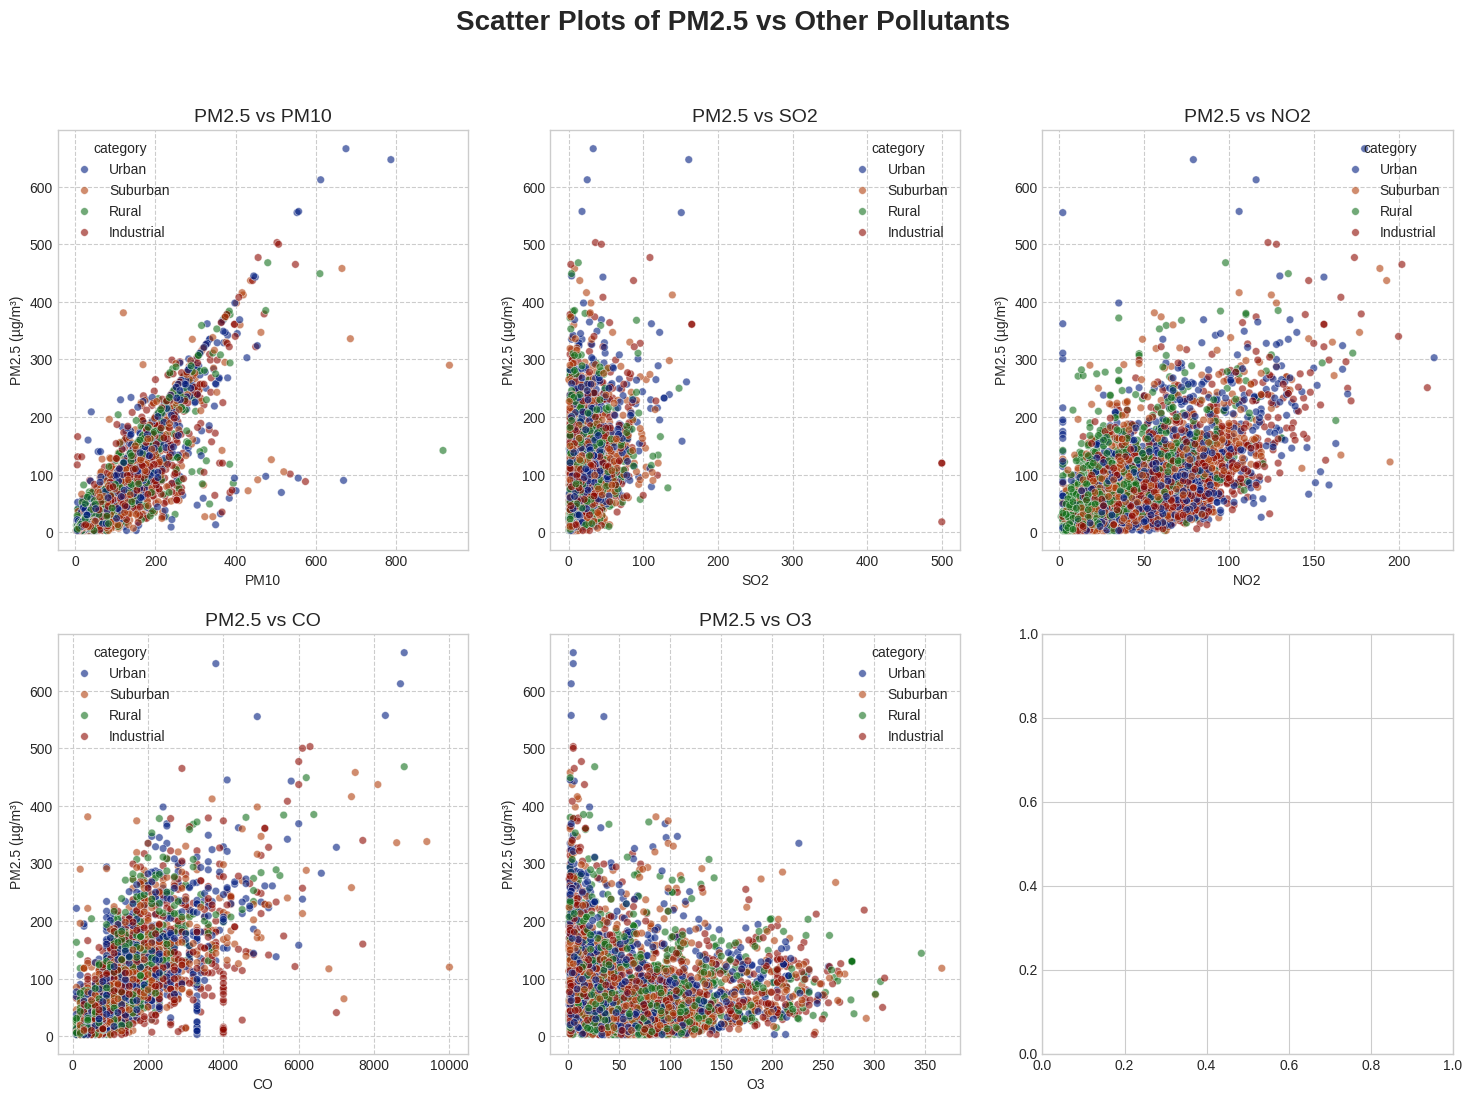

In [43]:
# Set up the subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Scatter Plots of PM2.5 vs Other Pollutants', fontsize=20, fontweight='bold')
pollutants = ['PM10', 'SO2', 'NO2', 'CO', 'O3']
for i, pollutant in enumerate(pollutants):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(ax=ax,x=pollutant,y='PM2.5',data=sample_df,hue='category',alpha=0.6,s=30,hue_order=category_order,palette='dark')
    ax.set_title(f'PM2.5 vs {pollutant}', fontsize=14)
    ax.set_xlabel(pollutant)
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.grid(True, linestyle='--')

##Multivariate Analysis

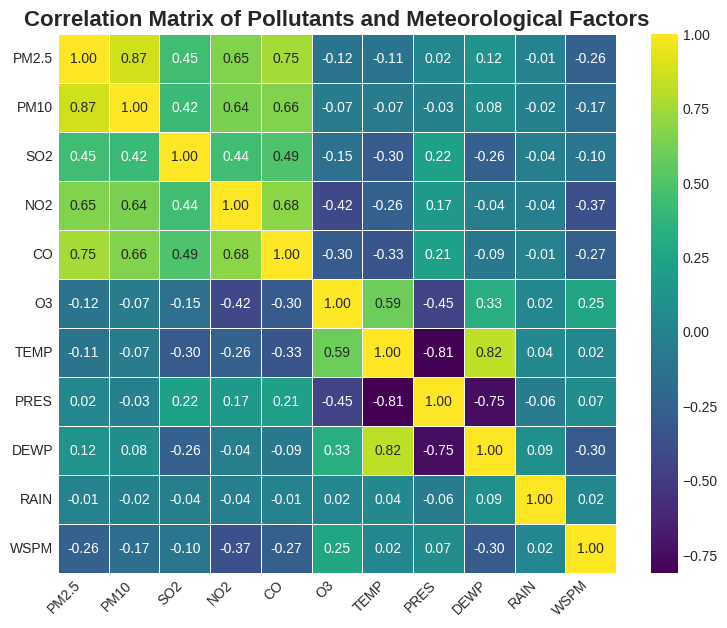

In [45]:
#Multivariate Analysis using Correlation Matrices
correlation_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
correlation_matrix = merged_df[correlation_columns].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, annot_kws={"size":10})
plt.title('Correlation Matrix of Pollutants and Meteorological Factors', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()